# Homework

You need to train the model and get score as big as you can

Dataset: https://disk.yandex.ru/d/gcGKZ_KsXZN4VA

### Prepare part

In [ ]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib

from IPython.display import clear_output

%matplotlib inline

In [ ]:
DEVICE = 'cpu' # 'cuda' #  # also you can use "cuda" for gpu and "mps" for apple silicon
DATADIR = 'ml_trains_data'
LOADER_WORKERS = 0

In [ ]:
class Dataset(torch_data.Dataset):
    def __init__(self, split_part: str, datadir: str, feats: nn.Module, read_labels=True):
        super().__init__()
        data = pd.read_csv(os.path.join(datadir, f'{split_part}.tsv'), sep='\t')
        print(data.head())
        if read_labels:
            labels = {key: idx for idx, key in enumerate(sorted(set(data.label.values)))}
            self._idx_to_label = {idx: key for idx, key in enumerate(sorted(set(data.label.values)))}
            self._classes = len(labels)
        self._feats = feats
        self._ytids = []
        self._pathes = []
        self._labels = []
        for _, row in data.iterrows():
            path = os.path.join(datadir, 'clips', f'{row.YTID}.flac')
            if os.path.exists(path):
                self._ytids.append(row.YTID)
                self._pathes.append(path)
                self._labels.append(labels[row.label] if read_labels else 0)

    def __getitem__(self, index):
        try:
            waveform, sample_rate = torchaudio.load(self._pathes[index])
        except Exception as err:
            logging.error("Can't read file %s", self._pathes[index])
            raise err
        assert sample_rate == 16000
        assert waveform.shape[0] == 1
        feats = self._feats(waveform)[0]
        return (feats, self._labels[index])

    def __len__(self) -> int:
        return len(self._pathes)

    def classes(self) -> int:
        return self._classes


def collate_fn(batch):
    max_length = max(item[0].shape[1] for item in batch)
    X = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    for idx, item in enumerate(batch):
        X[idx, :, :item[0].shape[1]] = item[0]
    targets = torch.tensor([item[1] for item in batch], dtype=torch.long).reshape(len(batch), 1)
    return (X, targets)

### Feats part

In [ ]:
# FBANK 40 by default, but you can choose something else
FEATS = 40
#transform = torchaudio.transforms.MelSpectrogram(n_mels=FEATS)
transform = torchaudio.transforms.MFCC(
        n_mfcc=13,
        log_mels=True,
        melkwargs={"n_fft": 400, "n_mels": FEATS})
trainset = Dataset('train', '/kaggle/input/open-dataset-for-sound-event-setected30-classses/ml_trains_data/', transform)
testset = Dataset('eval', '/kaggle/input/open-dataset-for-sound-event-setected30-classses/ml_trains_data/', transform, read_labels=False)
N_CLASSES = trainset.classes()
assert N_CLASSES == 30

                 YTID                       label
0   4i1aizhCnfg_30000                       Music
1  G3y5z37XW8E_200000                       Water
2   1imx8d_Ec_4_40000  Child speech, kid speaking
3   FJoR8b-lTgY_30000                      Engine
4   BDH7Fx1APR8_40000                       Music
                 YTID
0   _oDTEjyE75U_40000
1  5A-8VUzAC1M_180000
2   2sfvzpI4MPE_50000
3   M6w5HD8YIsY_60000
4   4IEpPBzMCN4_10000


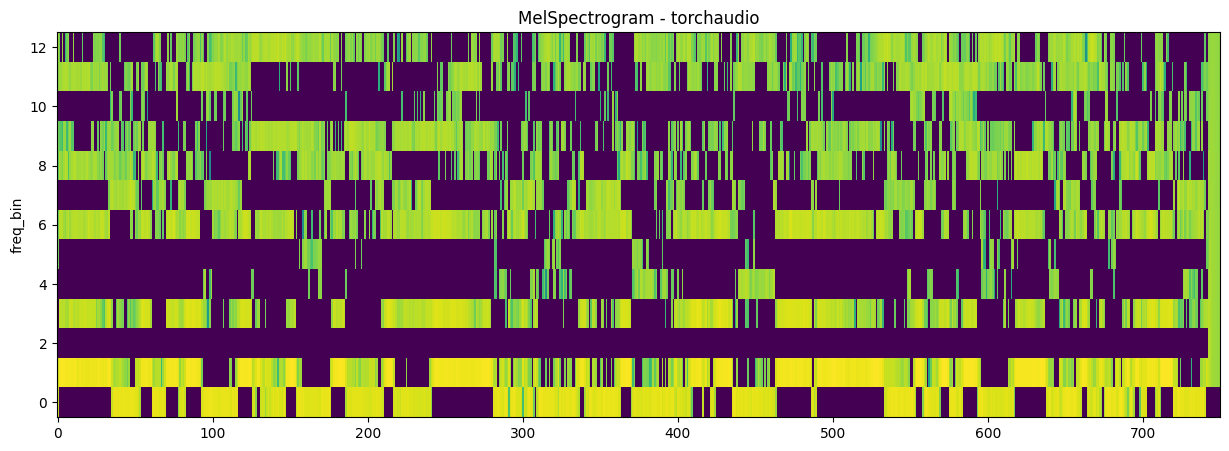

In [ ]:
import librosa
import matplotlib.pyplot as plt
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(15, 5))
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


plot_spectrogram(tmp[0], title="MelSpectrogram - torchaudio")

In [ ]:
tmp = trainset.__getitem__(10)
tmp[0].shape

torch.Size([13, 750])

In [ ]:
a = [(1, 2), (3, 4), (5, 6), (7, 8)]
x = np.array(a)
x[:, 0]

array([1, 3, 5, 7])

### Eval part

Write balanced accuracy:
$$BAcc = \frac{1}{classes}\sum_{c = 1}^{classes} \frac{\sum_i^n I(y_i = p_i = c)}{\sum_i^n I(y_i = c)}$$

Where:
- $y_i$ -- target class for $i$ element
- $p_i$ -- predicted class for $i$ element

In [ ]:
from sklearn.metrics import balanced_accuracy_score
# Get list of pairs (target_class, predicted_class)
def balanced_accuracy(items: list[tuple[int, int]], classes=N_CLASSES) -> float:
    inp = np.array(items)
    return balanced_accuracy_score(inp[:, 0], inp[:, 1])

In [ ]:
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 1)], 2), 1.0)
assert np.isclose(balanced_accuracy([(0, 1), (1, 0)], 2), 0.0)
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 0)], 2), 0.5)
assert np.isclose(balanced_accuracy([(0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (0, 1)], 2), 0.625)
assert np.isclose(balanced_accuracy([(1, 1), (0, 1), (2, 2)], 3), 0.66666666666666)

### Train part
Train some model with as big balanced accuracy as you can

You can train any model you want. The only limitation is that it must be trained from scratch on the data provided in the task. For example you can choose model from:
- DNN
- CNN 1d
- CNN 2d
- Transformer
- RNN
- mixes of given models

Hints:
- No need to train large models for this task. 10 million parameters is more than you need.
- Watch to overfitting, try to add Augmentation, Dropout, BatchNorm, L1/L2-Regulatization or something else.
- Use poolings or strides to reduce time-dimenstion. It is better to reduce the dimension gradually rather than at the end.
- Try different features (mel-spec, log-mel-spec, mfcc)

In [ ]:
def stage(
    model: nn.Module,
    data: torch_data.Dataset,
    opt: optim.Optimizer,
    batch_size: int = 256,
    train: bool = True
):
    loader = torch_data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn
    )
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, batches = 0.0, 0
    pred_pairs = []
    for X, Y in tqdm.tqdm(loader):
        pred = model.forward(X.to(DEVICE))
        loss = F.cross_entropy(pred.squeeze(), Y.squeeze().to(DEVICE))
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        loss_sum += loss.item()
        batches += 1
        with torch.no_grad():
            pred_pairs.extend(zip(
                Y.data.numpy().reshape(-1),
                torch.argmax(pred, dim=1).cpu().data.numpy().reshape(-1)
            ))
        if batches % 10 == 0:
            print(f"{batches} batches done")
    return loss_sum / batches, balanced_accuracy(pred_pairs)


def train(
    model: nn.Module,
    opt,
    batch_size: int = 256,
    epochs: int = 10,
):
    train_data, val_data = torch.utils.data.random_split(trainset, (0.9, 0.1), generator=torch.Generator().manual_seed(42))
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(epochs):
        print(f"Start {epoch + 1}")
        train_loss, train_acc = stage(model, train_data, opt, batch_size=batch_size)
        val_loss, val_acc = stage(model, val_data, opt, batch_size=batch_size, train=False)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train')
        axis[0].plot(np.arange(1, epoch + 2), val_losses, label='val')
        axis[1].plot(np.arange(1, epoch + 2), train_accs, label='train')
        axis[1].plot(np.arange(1, epoch + 2), val_accs, label='val')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='Accuracy')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_loss}. Train accuracy {train_acc}.')
        print(f'Test loss {val_loss}. Test accuracy {val_acc}')

In [ ]:
class SEDNet(nn.Module):
    def __init__(self, input_shape, filters=128, cnn_pooling=(5, 2, 2), rnn_units=(32, 32), dense_units=(32,), n_classes=1, dropout=0.5):
        super(SEDNet, self).__init__()

        self.cnn_layers = nn.ModuleList()
        in_channels = input_shape[-2]

        # Конволюционные слои и пулинг
        for pool in cnn_pooling:
            conv = nn.Sequential(
                nn.Conv2d(in_channels, filters, kernel_size=(3, 3), padding='same'),
                nn.BatchNorm2d(filters),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(1, pool)),
                nn.Dropout(dropout)
            )
            self.cnn_layers.append(conv)
            in_channels = filters

        # RNN слои
        self.rnn_layers = nn.ModuleList()
        for units in rnn_units:
            rnn = nn.GRU(input_size=filters, hidden_size=units, dropout=dropout, batch_first=True, bidirectional=True)
            self.rnn_layers.append(rnn)
            filters = units * 2  # Учитываем bidirectional

        # Полносвязные слои
        self.dense_layers = nn.ModuleList()
        for units in dense_units:
            dense = nn.Sequential(
                nn.Linear(filters, units),
                nn.Dropout(dropout)
            )
            self.dense_layers.append(dense)
            filters = units

        self.output_layer = nn.Linear(filters, n_classes)
        self.activation = nn.Sigmoid()  # Активация на выходе

    def forward(self, x):
        # Применение CNN слоев
        for conv in self.cnn_layers:
            x = conv(x)

        # Перестановка и изменение формы тензора
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)  # Изменение формы

        # Применение RNN слоев
        for rnn in self.rnn_layers:
            x, _ = rnn(x)

        # Применение Dense слоев
        for dense in self.dense_layers:
            x = dense(x)

        x = self.output_layer(x)
        x = self.activation(x)  # Активация на выходе
        return x

In [ ]:
FEATS = 13
class Model(nn.Module):
    def __init__(self, in_dim=FEATS, out_dim=N_CLASSES, filters=16, cnn_pooling=(4, 4, 4), rnn_units=(32, 32), dense_units=(32,), d=257):
        super().__init__()
        self.cnn_layers = nn.ModuleList()
        in_channels = in_dim
        dropout = 0.2

        for pool in cnn_pooling:
            conv = nn.Sequential(
                nn.Conv1d(in_channels, filters, kernel_size=4),
                nn.BatchNorm1d(filters),
                nn.ReLU(),
                nn.MaxPool1d(pool, stride=pool-1),
                nn.Dropout(dropout)
            )
            self.cnn_layers.append(conv)
            in_channels = filters

        filters = filters * d
       # RNN слои
        self.rnn_layers = nn.ModuleList()
        for units in rnn_units:
            rnn = nn.GRU(input_size=filters, hidden_size=units, dropout=dropout, batch_first=True, bidirectional=True)
            self.rnn_layers.append(rnn)
            filters = units * 2  # Учитываем bidirectional


        self.dense_layers = nn.ModuleList()
        for units in dense_units:
            dense = nn.Sequential(
                nn.Linear(filters, units),
                nn.Dropout(dropout)
            )
            self.dense_layers.append(dense)
            filters = units

        self.output_layer = nn.Linear(filters, out_dim)
        self.activation = nn.LogSoftmax()

    def forward(self, x):
        # input: [batch_size, IN_FEATURES, TIME]
        # output: [batch_size, N_CLASSES]
        for conv in self.cnn_layers:
            x = conv(x)

        # Перестановка и изменение формы тензора
        x = x.view(x.size(0), x.size(1), -1)  # Изменение формы
        x = torch.flatten(x, 1)
        # Применение RNN слоев
        for rnn in self.rnn_layers:
            x, _ = rnn(x)


        # Применение Dense слоев
        for dense in self.dense_layers:
            x = dense(x)

        x = self.output_layer(x)
        x = self.activation(x, 1)  # Активация на выходе
        return x

In [ ]:
trainset.__getitem__(0)[0].shape

torch.Size([13, 801])

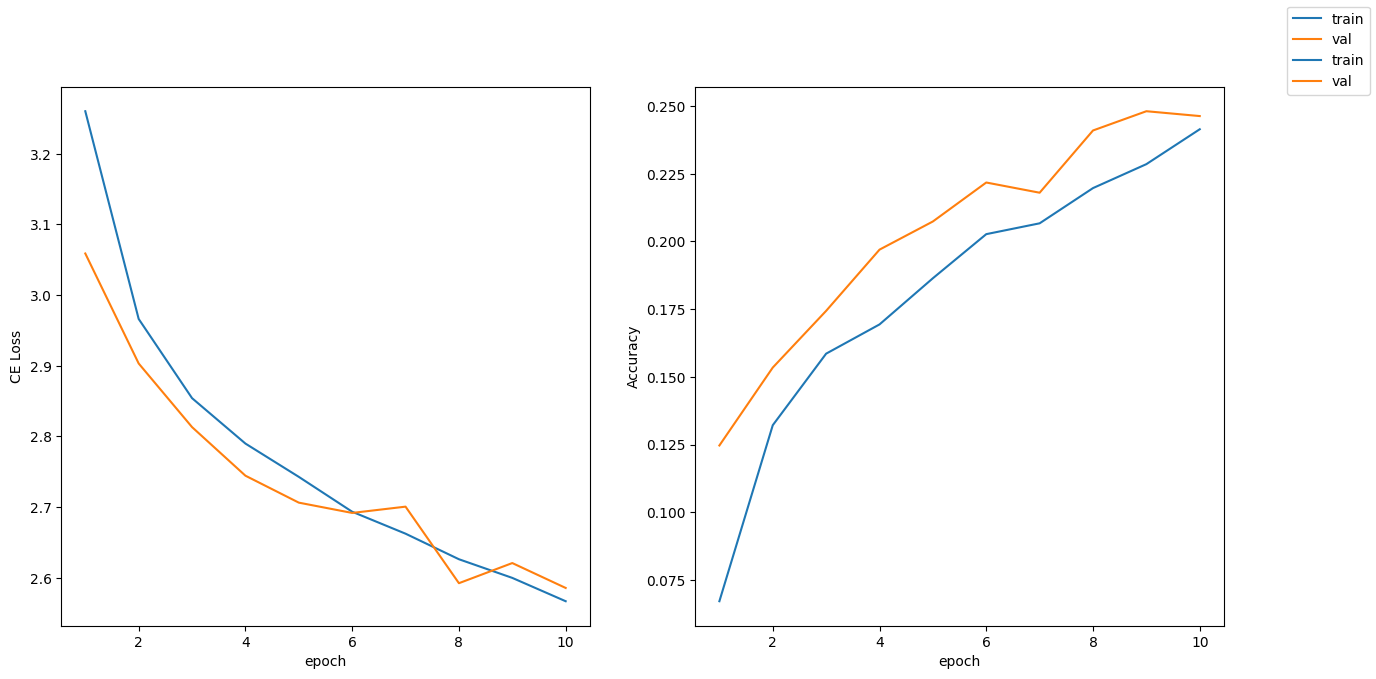

Epoch 10.
Train loss 2.566697592376381. Train accuracy 0.24144692079414318.
Test loss 2.585479346188632. Test accuracy 0.24631501216111618


In [ ]:
model = Model()
model = model.to(DEVICE)
opt = optim.Adam(model.parameters())
train(model, opt)#, epochs=25)

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
model = Model().to(DEVICE)
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

### Prediction part

Prepare result file and send it to Yandex.Contest

In [ ]:
a = collate_fn_X(testset)


In [ ]:
def collate_fn_X(batch):
    max_length = max(item[0].shape[1] for item in batch)
    X = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    for idx, item in enumerate(batch):
        X[idx, :, :item[0].shape[1]] = item[0]
    targets = torch.tensor([item[1] for item in batch], dtype=torch.long).reshape(len(batch), 1)
    return X

In [ ]:
result = []
for idx, ytid in enumerate(testset._ytids):
    feats = a[idx]
    predict = torch.argmax(model.forward(feats.reshape(1, FEATS, -1).to(DEVICE)), dim=1).item()
    result.append((ytid, trainset._idx_to_label[predict]))
pd.DataFrame(result, columns=['YTID', 'label']).to_csv('result.tsv', sep='\t', index=False)

torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size([13, 801])
torch.Size